In this notebook, I will test the code in physics.py which has been adapted from the code used for the expanding shells in [Feddersen et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...862..121F/abstract). I will be testing the physical calculations on a well-studied and isolated outflow: V380 Ori-NE

![title](finder_tanabe_39_12co_5_50_5sig.pdf)

The contours on this image go from 5 to 50 $\sigma$ in steps of 10 $\sigma$.

To calculate the outflow mass, we need two steps:

1. Extract the pixels in each outflow lobe.
2. Sum the pixels and calculate the total mass with the standard radiative transfer assumptions.

I'll focus first on Step 2, assuming the outflow emission dominates in the rectangular region shown in the finder images and is thus trivial to extract.

First, let's extract the blue lobe, using velocities less than 4.7 km/s, as shown in the figure above. We'll use the `spectral_cube` package.

In [79]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "..")
from stamp import *
from spectral_cube import wcs_utils

t_hops = Table.read("../../catalogs/hops.fits")
c12 = SpectralCube.read("../../cubes/mask_imfit_12co_pix_2_Tmb.fits")
c13 = SpectralCube.read("../../cubes/mask_imfit_13co_pix_2_Tmb_regrid12co.fits")
print(c12.header['DATE-OBS'], c13.header['DATE-OBS'], SpectralCube.read("../../cubes/mask_imfit_13co_pix_2_Tmb.fits").header['DATE-OBS'], SpectralCube.read("../../cubes/mask_imfit_c18o_pix_2_Tmb.fits").header['DATE-OBS'])
sig12, sig13 = 0.86*u.K, 0.64*u.K

hops_169 = t_hops[t_hops["HOPS"] == 169][0]
coord = SkyCoord(hops_169["RAJ2000"], hops_169["DEJ2000"], unit=u.deg)
width=height=4*u.arcmin
vmin, vmax = -2*u.km/u.s, 4.7*u.km/u.s
sub12 = extract_subcube(c12, region_class=RectangleSkyRegion,
                      region_kwargs=dict(center=coord, width=width, height=height))
sub13 = extract_subcube(c13, region_class=RectangleSkyRegion,
                        region_kwargs=dict(center=coord, width=width, height=height))
print(wcs_utils.check_equality(sub12.wcs, sub13.wcs, wcs_tolerance=1e-2, warn_missing=True))
# print(sub12.wcs.to_header(), sub13.wcs.to_header())
# print(sub12.header, sub13.header)
slab12_blue = sub12.spectral_slab(vmin, vmax)
slab13_blue = sub13.spectral_slab(vmin, vmax)

1985-02-15T03:11:26.2 1984-09-21T23:22:32.4 1984-09-21T23:22:32.4 1985-07-02T06:03:42.6
True


Now we have a subcube of the blue channels around the outflow source, with the width and height specified above. Let's look at the moment0 map of the blue lobe to verify we've extracted it properly.

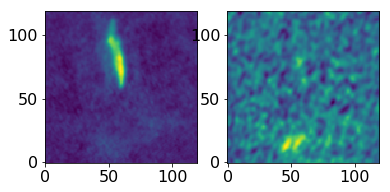

In [80]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(slab12_blue.moment0().data, origin='lower')
ax[1].imshow(slab13_blue.moment0().data, origin='lower')

We see above the integrated 12co emission from the blue lobe of this outflow. But we also see some diffuse noise around the outflow. We probably want to only include pixels above some sigma threshold in our calculations. The median noise per channel is given in Table 2 of Kong et al. (2018). In 12co, this is 0.86 K. In 13co, it is 0.64 K. To propagate this noise to the integrated moment0 map:

### Noise Threshold

In [81]:
def sigma_mom0(cube, channel_sigma=0.86*u.K):
        channel_width = cube.spectral_axis[1] - cube.spectral_axis[0]
        sigma_mom0 =  channel_width * np.sqrt(cube.spectral_axis.size * channel_sigma ** 2.)
        return sigma_mom0 
print("Noise in the Moment-0 map is", sigma_mom0(slab12_blue))

Noise in the Moment-0 map is 1137.9934201556018 K m / s


Let's try masking out all pixels below 3, 5, and 10$\sigma$

32411338.0 K m / s


Text(0.5, 1.0, '10 sigma total: 1.42e+07 K m / s')

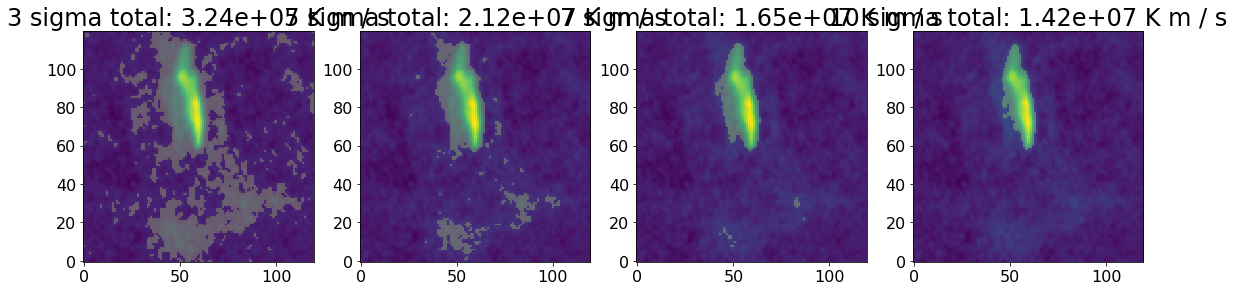

In [82]:
mom0_blue = slab12_blue.moment0()
sigmom0_blue = sigma_mom0(slab12_blue)
fig, ax = plt.subplots(1,4, figsize=(19,5))
ax[0].imshow(mom0_blue > 3*sigmom0_blue, origin='lower')
ax[0].imshow(mom0_blue.data, origin='lower', alpha=0.8)
print(np.nansum(mom0_blue[mom0_blue > 3*sigmom0_blue]))
ax[0].set_title("3 sigma total: {:.3g}".format(np.nansum(mom0_blue[mom0_blue > 3*sigmom0_blue])))
ax[1].imshow(mom0_blue > 5*sigmom0_blue, origin='lower')
ax[1].imshow(mom0_blue.data, origin='lower', alpha=0.8)
ax[1].set_title("5 sigma total: {:.3g}".format(np.nansum(mom0_blue[mom0_blue > 5*sigmom0_blue])))
ax[2].imshow(mom0_blue > 7*sigmom0_blue, origin='lower')
ax[2].imshow(mom0_blue.data, origin='lower', alpha=0.8)
ax[2].set_title("7 sigma total: {:.3g}".format(np.nansum(mom0_blue[mom0_blue > 7*sigmom0_blue])))
ax[3].imshow(mom0_blue > 10*sigmom0_blue, origin='lower')
ax[3].imshow(mom0_blue.data, origin='lower', alpha=0.8)
ax[3].set_title("10 sigma total: {:.3g}".format(np.nansum(mom0_blue[mom0_blue > 10*sigmom0_blue])))

For this outflow lobe, a threshold of 10$\sigma$ seems to work well, but might be slightly aggressive. There is a tradeoff between how aggressively we define the velocity range of the outflow to include the most outflow channels possible an the noise threshold needed to exclude unrelated emission. Clearly, much of the emission to the south is not noise but is cloud emission at the high end of the velocity range, ~ 4.5 km/s. In the case of a perfectly isolated outflow, a threshold of $5\sigma$ would probably be appropriate to exclude noise from the calculations. A more sophisticated method for extracting the outflow lobes from the moment0 maps would also help justify sticking to a threshold of 5$\sigma$. But let's leave that for now and move forward with the 10$\sigma$ threshold. 

The total 12co integrated emission in the blue lobe (above $10\sigma$) is $1.42\times10^7~\rm{K~m~s}^{-1}$

Another way to extract significant emission is on a channel-by-channel basis. In this method, we would select only those pixels that excede some threshold in each channel map. Let's see how this differs from choosing thresholds based on the moment0 map as done above.

Text(0.5, 1.0, '10 sigma channel-by-channel, total: 4.01e+06 K m / s')

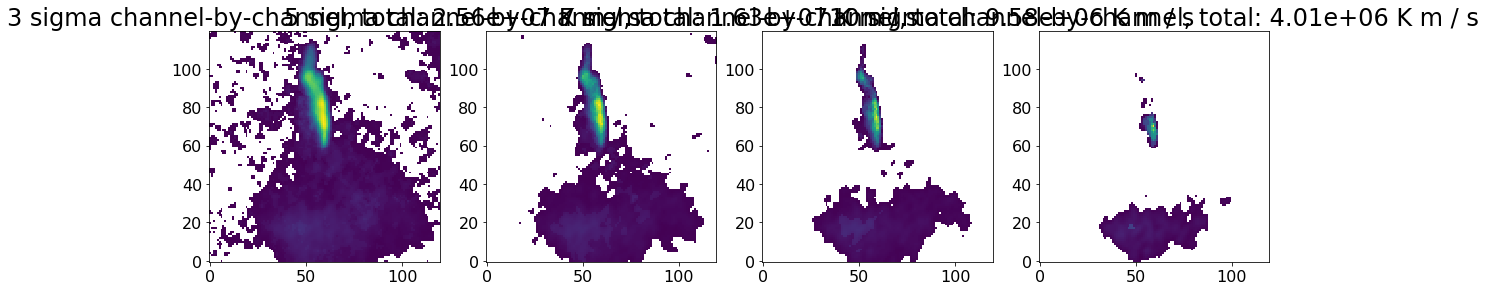

In [83]:
channel_sigma = 0.86*u.K
slab12_blue_3sig = slab12_blue.with_mask(slab12_blue > 3*channel_sigma)
slab12_blue_5sig = slab12_blue.with_mask(slab12_blue > 5*channel_sigma)
slab12_blue_7sig = slab12_blue.with_mask(slab12_blue > 7*channel_sigma)
slab12_blue_10sig = slab12_blue.with_mask(slab12_blue > 10*channel_sigma)
fig, ax = plt.subplots(1,4, figsize=(19,5))
ax[0].imshow(slab12_blue_3sig.moment0().data, origin='lower')
ax[0].set_title("3 sigma channel-by-channel, total: {:.3g}".format(np.nansum(slab12_blue_3sig.moment0())))
ax[1].imshow(slab12_blue_5sig.moment0().data, origin='lower')
ax[1].set_title("5 sigma channel-by-channel, total: {:.3g}".format(np.nansum(slab12_blue_5sig.moment0())))
ax[2].imshow(slab12_blue_7sig.moment0().data, origin='lower')
ax[2].set_title("7 sigma channel-by-channel, total: {:.3g}".format(np.nansum(slab12_blue_7sig.moment0())))
ax[3].imshow(slab12_blue_10sig.moment0().data, origin='lower')
ax[3].set_title("10 sigma channel-by-channel, total: {:.3g}".format(np.nansum(slab12_blue_10sig.moment0())))

### Excitation Temperature

We need the excitation temperature, which we can get from the gaussian fit to the average spectrum in a small region around the outflow source. Here I'll show spectral fits in three different regions around the outflow.

1. Fit Average Spectrum in 5 arcminute box.

Guessing these parameters:  {'amplitude': 35.234474, 'mean': 8813.994314077, 'stddev': 10002.815891560002}
32.86315774468758 K


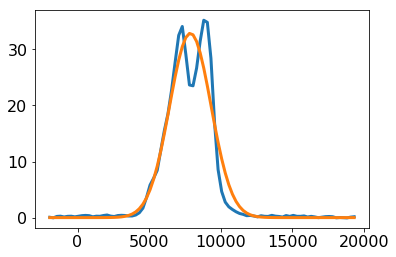

In [84]:
spec_large = sub12.mean((1,2))
gauss = fit_gaussian(spec_large.spectral_axis.value, spec_large.value, autoguess=True)
plot_spectrum(spec_large)
plt.plot(spec_large.spectral_axis.value, gauss(spec_large.spectral_axis.value))
Tex = gauss.amplitude*u.K
print(Tex)

2. Fit Average Spectrum in Small 15 Arsecond Region Around Source

Guessing these parameters:  {'amplitude': 50.97399, 'mean': 8813.994314077, 'stddev': 9752.745494271001}
38.835634888103066 K


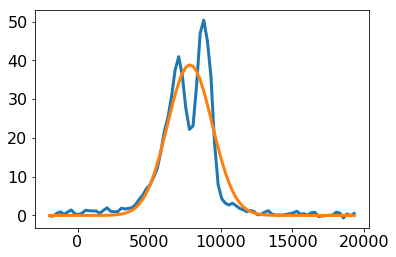

In [85]:
subcube_fit = extract_subcube(sub12, CircleSkyRegion, 
        region_kwargs={'center':coord,
                       'radius':15*u.arcsec})
spec_small = subcube_fit.mean((1,2))
gauss = fit_gaussian(spec_small.spectral_axis.value, spec_small.value, autoguess=True)
plot_spectrum(spec_small)
plt.plot(spec_small.spectral_axis.value, gauss(spec_small.spectral_axis.value))
Tex = gauss.amplitude*u.K
print(Tex)

3. Fit Average Spectrum Within Outflow Lobe

Guessing these parameters:  {'amplitude': 34.881348, 'mean': 9064.064711366, 'stddev': 4001.1263566239995}
30.003543397712583 K


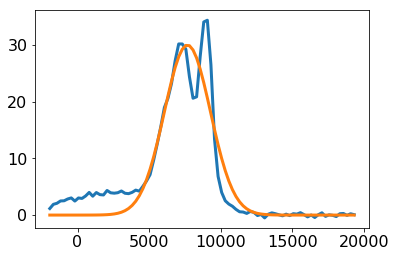

In [86]:
spec_blue = sub12.with_mask(mom0_blue > 10*sigmom0_blue).mean((1,2))
gauss = fit_gaussian(spec_blue.spectral_axis.value, spec_blue.value, autoguess=True)
plot_spectrum(spec_blue)
plt.plot(spec_blue.spectral_axis.value, gauss(spec_small.spectral_axis.value))
Tex = gauss.amplitude*u.K
print(Tex)

Comparing all 3 averaged spectra:

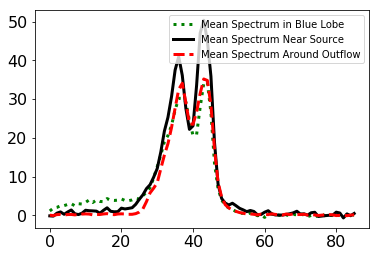

In [87]:
plt.plot(spec_blue, "g:", label="Mean Spectrum in Blue Lobe")
plt.plot(spec_small, "k-", label="Mean Spectrum Near Source")
plt.plot(spec_large, "r--", label="Mean Spectrum Around Outflow")
plt.legend()

This might be useful: If we subtract the spectrum of the environment around the outflow, that is, the mean spectrum in a box 5 arcminutes on a side centered on the outflow source, from the mean spectrum of the region where the blue lobe is above $10\sigma$, we see a spectrum of the blue lobe.

Text(0.5, 1.0, 'Mean Blue Lobe Spectrum - Mean Environment Spectrum')

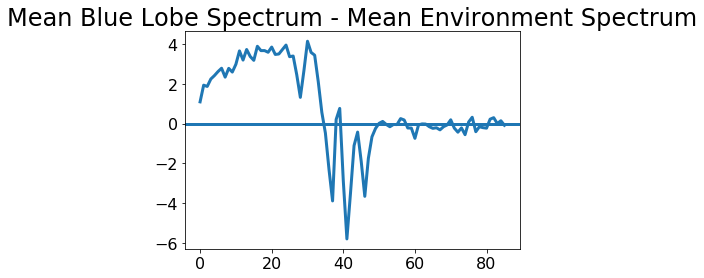

In [88]:
plt.plot(spec_blue - spec_large)
plt.axhline(0)
plt.title("Mean Blue Lobe Spectrum - Mean Environment Spectrum")

Now that we have calculated the excitation temperature, we can use this to compute the column density of H2 corresponding to the integrated 12CO, assuming 12CO is optically thin. We know that 12CO is NOT in fact optically thin, so we'll also need to adopt some sort of optical depth correction. This could be something like I did in the shells paper, or something like Tanabe does (adopt an average value) or some other optical depth correction entirely. This will require the use of 13CO.

### 12co Opacity Correction

1. Tanabe et al. (2019) Method

To estimate the optical depth of 12CO outflows, Tanabe et al. searched for outflows with 13CO emission. Using the same velocity range as they determined for the 12CO outflows, they identified outflows with integrated 13CO above 3$\sigma$ and where the 13CO peak was within the 12CO outflow lobe. Only a few of the outflow lobes in their study are detected in 13CO. Using those cases with both 12CO and 13CO detected, they calculate the optical depth of 12CO using the standard formula, which assumes that 12CO and 13CO are in LTE with the same excitation temperature:

$$\frac{I_{^{12}\text{CO}}}{I_{^{13}\text{CO}}} = \frac{1 - \exp(-\tau_{^{12}\text{CO}})}{1 - \exp(-\tau_{^{13}\text{CO}})}$$

where $I_{^{12}\text{CO}}$ is the average integrated intensity of $^{12}$CO above 5$\sigma$ and $I_{^{13}\text{CO}}$ is the average integrated intensity of $^{13}$CO in the same pixels. If we assume the standard isotopic ratio, $\tau_{^{12}\text{CO}}$ / $\tau_{^{13}\text{CO}}$ = 62, we can use this equation to solve for the optical depth of $^{12}$CO:



Tanabe et al. applied the average optical depth (~5) from the few outflows they detected in both 12 and 13CO to the rest of their outflows.

Using this method on our outflow, but with the 10$\sigma$ contour instead of the $5\sigma$ one that Tanabe used. **This outflow does not contain any significant (> 3$\sigma$) 13CO emission towards the blue lobe.**

nan K m / s
nan K m / s
nan


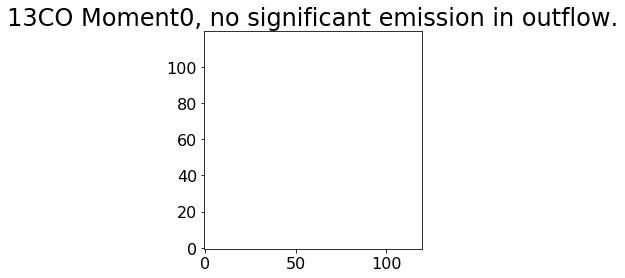

In [89]:

sigmom0_blue13 = sigma_mom0(slab13_blue, 0.64*u.K)


mom0_blue13 = slab13_blue.moment0()

ii_10sig12_3sig13 = (mom0_blue > 10*sigmom0_blue) & (mom0_blue13 > 3*sigmom0_blue13)
plt.imshow(np.ma.masked_array(mom0_blue13.data, mask=~ii_10sig12_3sig13), origin='lower')
# plt.imshow(np.ma.masked_array(mom0_blue13.data, mask=False), origin='lower')
plt.title("13CO Moment0, no significant emission in outflow.")
I_13 = mom0_blue13[ii_10sig12_3sig13].mean()
print(I_13)
I_12 = mom0_blue[ii_10sig12_3sig13].mean()
print(I_12)
correct_factor = 1./((I_12/I_13)/62.)
print(correct_factor)

However, if we instead look for 13co at lower (closer to cloud) velocites, we do see a bit of emission (see below). In general, we may need to look closer to the cloud velocities for the 13co counterpart to the 12co outflows.

3311.59912109375 K m / s
28784.833984375 K m / s
Correction factor with 3sigma 13co moment0 and 10sigma 12co moment0 7.132893162394613
Correction factor with 3sigma 13co channel intensity and 10 sigma 12co moment0 2.606617436490676
1029.3865966796875 K m / s


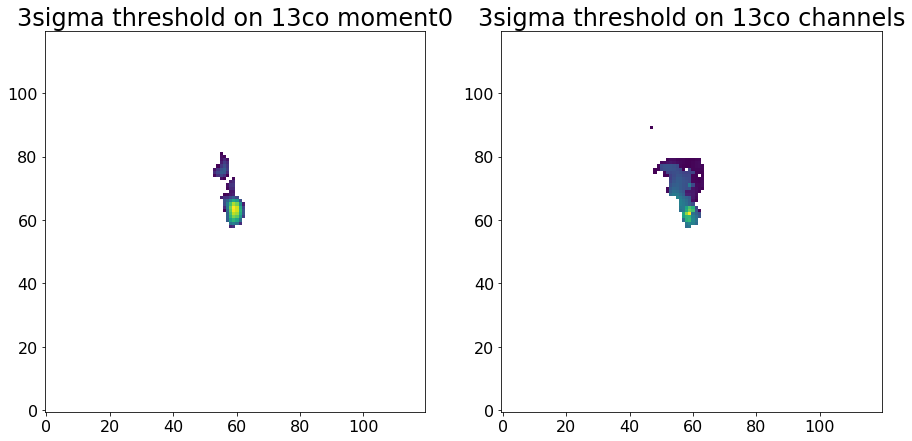

In [90]:
slab = sub13.spectral_slab(-2*u.km/u.s, 6*u.km/u.s)
blue13_3sig = slab.with_mask(slab > 3*sig13)
mom0_blue13 = slab.moment0()
mom0_blue13_3sig = blue13_3sig.moment0()
sigmom0_blue13 = sigma_mom0(slab, 0.64*u.K)
ii_10sig12_3sig13 = (mom0_blue > 10*sigmom0_blue) & (mom0_blue13 > 3*sigmom0_blue13)
ii_10sig12 = (mom0_blue > 10*sigmom0_blue)
I_13 = mom0_blue13[ii_10sig12_3sig13].mean()
print(I_13)
I_12 = mom0_blue[ii_10sig12_3sig13].mean()
print(I_12)
fig, ax = plt.subplots(1,2, figsize=(15,8))
correct_factor = 1./((I_12/I_13)/62.)
print("Correction factor with 3sigma 13co moment0 and 10sigma 12co moment0", correct_factor)
ax[0].imshow(np.ma.masked_array(mom0_blue13.data, mask=~ii_10sig12_3sig13), origin='lower')
ax[0].set_title("3sigma threshold on 13co moment0")

correct_factor = 1./((np.nanmean(mom0_blue[ii_10sig12])/np.nanmean(mom0_blue13_3sig[ii_10sig12]))/62.)
print("Correction factor with 3sigma 13co channel intensity and 10 sigma 12co moment0", correct_factor)
ax[1].imshow(np.ma.masked_array(mom0_blue13_3sig.data, mask=~ii_10sig12), origin='lower')
ax[1].set_title("3sigma threshold on 13co channels")
print(np.nanmean(mom0_blue13_3sig[ii_10sig12]))

2. Dunham et al. (2014) Method: Variable T$_{ex}$ and Opacity

This method was used by: Plunkett et al. (2015), Zhang et al. (2016), in a similar way by Feddersen et al. (2018, shells).
From Dunham et al. (2014), Equation 2, if we assume 13CO is optically thin, we can compute a velocity-dependent $\tau_{^{12}\text{CO}}(v)$ by solving:

$$\frac{T_{^{12}\text{CO}}}{T_{^{13}\text{CO}}} = \frac{[^{12}\text{CO}]}{[^{13}\text{CO}]}\frac{1 - \exp(-\tau_{^{12}\text{CO}})}{\tau_{^{12}\text{CO}}}$$

where $\frac{[^{12}\text{CO}]}{[^{13}\text{CO}]}$ is the abundance ratio, assumed to be 62 from Langer and Penzias (1993).

In [91]:
sig12, sig13 = 0.86*u.K, 0.64*u.K
sig13



<Quantity 0.64 K>

(Beam: BMAJ=10.010999813688 arcsec BMIN=8.091999962928 arcsec BPA=-12.8900003433 deg,
 Beam: BMAJ=7.620999868944001 arcsec BMIN=6.155000813304 arcsec BPA=9.93999958038 deg)

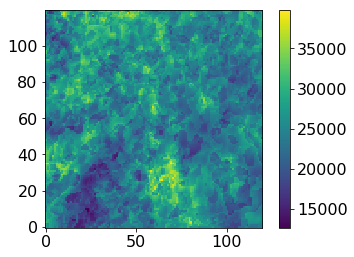

In [131]:
from spectral_cube import wcs_utils
from spectral_cube import BooleanArrayMask
# ii_3sig12_boo = BooleanArrayMask(np.array(sub12) > 3*sig12.value, sub12.wcs)
ii_3sig12 = sub12 > 3*sig12
ii_3sig13 = sub13 > 3*0.35*u.K
ii_3sig12_3sig13 = ii_3sig12 & ii_3sig13

sub_ratio_3sig = (sub12/sub13).with_mask(ii_3sig12_3sig13)

im=plt.imshow(sub_ratio_3sig.moment0().data, origin='lower')
plt.colorbar()
c12.beam, c13.beam

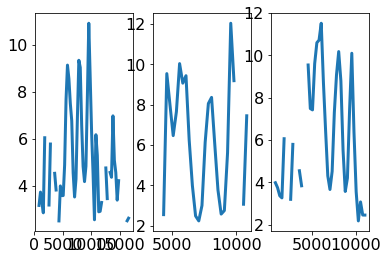

In [132]:

meanspec_ratio = sub_ratio_3sig.mean((1,2))
stdspec_ratio = sub_ratio_3sig.std((1,2))

ratio_central = extract_subcube(sub_ratio_3sig, CircleSkyRegion, 
            region_kwargs={'center':coord,
                           'radius':15*u.arcsec})
meanspec_ratio_central = ratio_central.mean((1,2))

ratio_bluelobe = sub_ratio_3sig.with_mask(mom0_blue > 10*sigmom0_blue)
meanspec_ratio_bluelobe = ratio_bluelobe.mean((1,2))
# print(meanspec_ratio_bluelobe.spectral_axis)
fig, ax = plt.subplots(1,3)
ax[0].plot(meanspec_ratio.spectral_axis, meanspec_ratio)
ax[1].plot(meanspec_ratio_central.spectral_axis, meanspec_ratio_central)
ax[2].plot(meanspec_ratio_bluelobe.spectral_axis, meanspec_ratio_bluelobe)

### Using C18O to get the systematic velocity.
Many outflow studies (like Dunham et al. 2014) use the cloud velocity to compare to the outflow velocities, and for calculating things like outflow momentum and kinetic energy. I use the best-fit models to find this for the shells. In the case of outflows, I expect their sources to be much younger, more embedded, and therefore kinematically tied to the surrounding dense gas. I'll try to use C18O to constrain the "core" central velocity of the outflows. We could also use NH3+

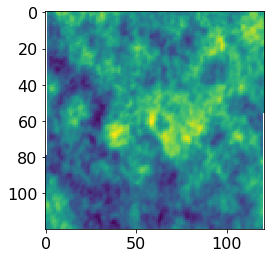

In [94]:
c18 = SpectralCube.read("../../cubes/mask_imfit_c18o_pix_2_Tmb.fits")
sub18 = extract_subcube(c18, region_class=RectangleSkyRegion,
                        region_kwargs=dict(center=coord, width=width, height=height))
sub18.moment0().quicklook()
c18o_aperture = extract_subcube(sub18, CircleSkyRegion, 
            region_kwargs={'center':coord,
                           'radius':15*u.arcsec})
meanspec_c18o = extract_spectrum(c18o_aperture)

Guessing these parameters:  {'amplitude': 4.8685207, 'mean': 6970.818015333999, 'stddev': 1650.2114691449997}


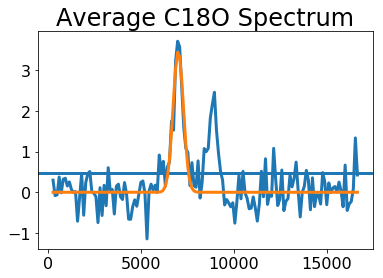

In [95]:
plt.plot(meanspec_c18o.spectral_axis, meanspec_c18o)
plt.axhline(1*0.47)
plt.title("Average C18O Spectrum")
gauss = fit_gaussian(meanspec_c18o.spectral_axis.value, meanspec_c18o.value, autoguess=True)
plt.plot(meanspec_c18o.spectral_axis.value, gauss(meanspec_c18o.spectral_axis.value))

### Searching for 13CO Outflow at Lower Velocities

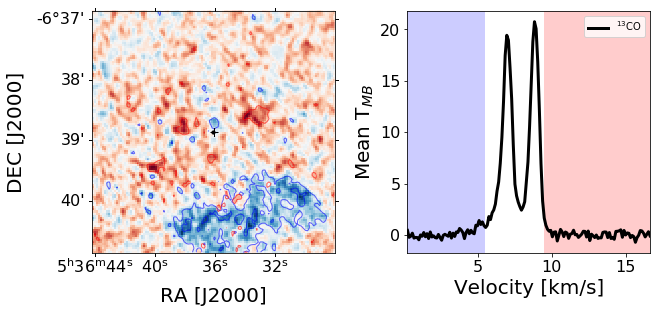

In [96]:
matplotlib.style.use("presentation")
c13 = SpectralCube.read("../../cubes/mask_imfit_13co_pix_2_Tmb.fits")
do_fit = 0
nsigma_vel = 2.
blue_vel = [-2,5.5]*u.km/u.s
red_vel = 9.5*u.km/u.s
fit_radius = 15*u.arcsec
width = height = 4*u.arcmin
start = 5.
stop = 50.
step = 5.
fig = plt.figure(figsize=(10,5))
plot_finder(c13, coord=coord,
            fit_cube=c13, fit_radius=fit_radius,
            nsigma_vel=nsigma_vel, blue_vel=blue_vel, red_vel=red_vel,
            fit_spectrum=do_fit, channel_sigma=sig13,
            region_width=width, region_height=height,
            blue_levels=np.arange(start, stop+step, step), red_levels=np.arange(start, stop+step, step),
            show_stamp=True, show_catalogs=True, show_spectrum=True, show_fit=do_fit,
            show_fitcircle=False, show_vrange=True, interactive=False, show_name=False,
            show_contour=1, show_redblue=True, show_outflows=False, redblue_mode='subtract',
            imshow_kwargs={"cmap":"RdBu_r", "interpolation":"none"},
            blue_contour_kwargs={'colors':'blue', 'linewidths':1, 'alpha':0.6, 'zorder':3},
            red_contour_kwargs={'colors':'red', 'linewidths':1, 'alpha':0.6, 'zorder':3},
            fig=fig, savefig=False, verbose=False, autoguess=True,
            spec_label=r'$^{13}$CO'
            )
plt.show()

There may be a very small bit of blueshifted 13CO at lower velocities toward the blue lobe to the North of the source. But this doesn't really amount to much, and also how would we use this to calculate the velocity-dependent opacity, because the 12 and 13co outflows are at different velocities. Could perhaps use the lower velocity window to compute the integrated ratio, to mimic the Tanabe method of opacity correction. I have added this to the opacity correction section above. Indeed, adopting a blue velocity range of -2 to 6 km/s for 13co gives enough significant 13co emission in the blue lobe to calculate an opacity correction method with the ratio of integrated 12co/13co.

### Correcting for Low-Velocity Outflow Emission
Method is from Section 4.3 of Dunham et al. (2014). First, we make a mass spectrum of the outflow by summing the total mass (opacity-corrected) in each velocity channel over the whole extent of the outflow. So, we must sum up the mass (for now, the CO intensity, assuming we just adopt a single opacity correction factor and excitation factor for each outflow) only in pixels in the outflow. We should also threshold the cube to only sum pixels above 3sigma.

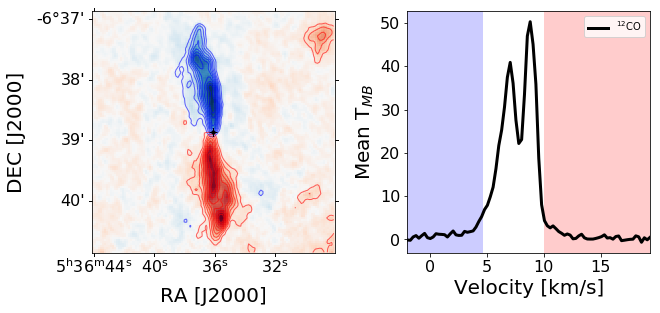

In [97]:
matplotlib.style.use("presentation")
do_fit = 0
nsigma_vel = 2.
blue_vel = 4.7*u.km/u.s
red_vel = 10.*u.km/u.s
fit_radius = 15*u.arcsec
width = height = 4*u.arcmin
start = 10.
stop = 50.
step = 5.
fig = plt.figure(figsize=(10,5))
plot_finder(c12, coord=coord,
            fit_cube=c12, fit_radius=fit_radius,
            nsigma_vel=nsigma_vel, blue_vel=blue_vel, red_vel=red_vel,
            fit_spectrum=do_fit, channel_sigma=sig13,
            region_width=width, region_height=height,
            blue_levels=np.arange(start, stop+step, step), red_levels=np.arange(start, stop+step, step),
            show_stamp=True, show_catalogs=True, show_spectrum=True, show_fit=do_fit,
            show_fitcircle=False, show_vrange=True, interactive=False, show_name=False,
            show_contour=1, show_redblue=True, show_outflows=False, redblue_mode='subtract',
            imshow_kwargs={"cmap":"RdBu_r", "interpolation":"none"},
            blue_contour_kwargs={'colors':'blue', 'linewidths':1, 'alpha':0.6, 'zorder':3},
            red_contour_kwargs={'colors':'red', 'linewidths':1, 'alpha':0.6, 'zorder':3},
            fig=fig, savefig=False, verbose=False, autoguess=True,
            spec_label=r'$^{12}$CO'
            )
plt.show()

In [98]:
sub_red = sub12.spectral_slab(red_vel, 20*u.km/u.s)
sub_blue = sub12.spectral_slab(-2*u.km/u.s, blue_vel)
sub_blue_3sig = sub_blue.with_mask(sub_blue > 3*sig12)
sub_red_3sig = sub_red.with_mask(sub_red > 3*sig12)
mom0_red = sub_red.moment0()
mom0_blue = sub_blue.moment0()
mom0_blue_3sig = sub_blue_3sig.moment0()
mom0_red_3sig = sub_red_3sig.moment0()

ii_10sig_mom0_red_3sig = mom0_red_3sig > 10*sigma_mom0(sub_red)
ii_10sig_mom0_blue_3sig = mom0_blue_3sig > 10*sigma_mom0(sub_blue)

68569080.0 K m / s 42059228.0 K m / s


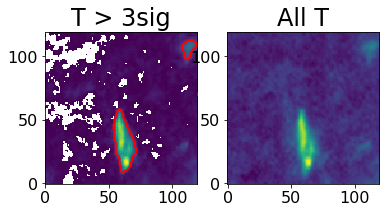

In [99]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(mom0_red_3sig.data, origin='lower')
ax[0].set_title('T > 3sig')
ax[1].imshow(mom0_red.data, origin='lower')
ax[1].set_title('All T')
print(mom0_red.sum(), np.nansum(mom0_red_3sig))
ax[0].contour(ii_10sig_mom0_red_3sig, colors='red', origin='lower', alpha=1, levels=0, linewidths=2)

46248020.0 K m / s 25556688.0 K m / s


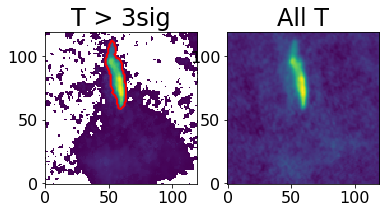

In [100]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(mom0_blue_3sig.data, origin='lower')
ax[0].set_title('T > 3sig')
ax[1].imshow(mom0_blue.data, origin='lower')
ax[1].set_title('All T')
print(mom0_blue.sum(), np.nansum(mom0_blue_3sig))
ax[0].contour(ii_10sig_mom0_blue_3sig, colors='red', origin='lower', alpha=1, levels=0, linewidths=2)

Now we define the full extent of the outflow as the joint 10sigma contour of the moment0 of both red and blue lobes. We'll also probably have to draw a region around the outflow to exclude bright extraneous cloud emission and other overlapping outflows, as can be seen in the upper-right of the red lobe moment0 map.

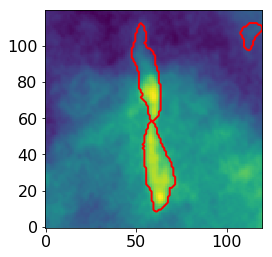

In [101]:
ii_10sig_joint = ii_10sig_mom0_blue_3sig | ii_10sig_mom0_red_3sig

plt.imshow(sub12.moment0().data, origin='lower')
plt.contour(ii_10sig_joint, colors='red', origin='lower', alpha=1, levels=0, linewidths=2)
# plt.imshow(sub12.moment0().data, origin='lower')

Guessing these parameters:  {'amplitude': 36775.383, 'mean': 8813.994314077, 'stddev': 10002.815891560002}
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean             stddev      
    ----------------- ----------------- ------------------
    33476.28058090591 7811.268496775373 1569.5944281413726


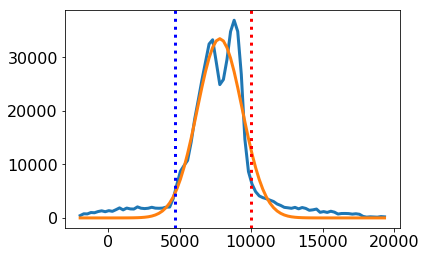

In [102]:
sub12_3sig = sub12.with_mask(sub12 > 3*sig12)
sub12_3sig_outflow = sub12_3sig.with_mask(ii_10sig_joint)
sumspec_outflow = sub12_3sig_outflow.sum((1,2))
plt.plot(sumspec_outflow.spectral_axis, sumspec_outflow)
gauss = fit_gaussian(sumspec_outflow.spectral_axis.value, sumspec_outflow.value, autoguess=True)
print(gauss)
plt.plot(sumspec_outflow.spectral_axis.value, gauss(sumspec_outflow.spectral_axis.value))
plt.axvline(blue_vel.value*1000, c='b', ls=':')
plt.axvline(red_vel.value*1000, color='red', ls=':')

This method doesn't work with multi-component cloud spectra, like we see toward this line of sight, because we can't cleanly fit a gaussian. 

In [1]:
# from astropy.modeling import models, fitting
# x = sumspec_outflow.spectral_axis.value
# y = sumspec_outflow.value
# g1_init = models.Gaussian1D(amplitude=3e4,
#                           mean=9000,
#                           stddev=1000)
# g2_init = models.Gaussian1D(amplitude=-1000,
#                           mean=7000,
#                           stddev=1000)
# # gg_init = g1_init + g2_init
# # fit_gg = fitting.SLSQPLSQFitter()
# fit_g = fitting.LevMarLSQFitter()

# g = fit_g(g_init, x, y)
# # gg = fit_gg(gg_init, x, y)

# plt.plot(sumspec_outflow.spectral_axis, sumspec_outflow)
# plt.plot(sumspec_outflow.spectral_axis.value, g(sumspec_outflow.spectral_axis.value))
# # plt.plot(sumspec_outflow.spectral_axis.value, gg(sumspec_outflow.spectral_axis.value))
# plt.axvline(blue_vel.value*1000, c='b', ls=':')
# plt.axvline(red_vel.value*1000, color='red', ls=':')

# # def fit_gaussian_multi(x, y, autoguess=False, gaussian_kwargs={"amplitude":[1.,1.], "mean":[0,0], "stddev":[1.,1.]},
# #         fit_kwargs={}):
#     if autoguess:
#         gaussian_kwargs={"amplitude":y.max() - y.min(),
#                 "mean":x[y.argmax()],
#                 "stddev":abs(x[y.argmax()] - x[y.argmin()])}
#         print("Guessing these parameters: ", gaussian_kwargs)
#     g_init = models.Gaussian1D(**gaussian_kwargs)
#     fit_g = fitting.LevMarLSQFitter()
#     g = fit_g(g_init, x, y, **fit_kwargs) 
#     return g


IndentationError: unexpected indent (<ipython-input-1-bd27d0bc61cb>, line 25)

### Calculating the Mass from CO 

In [105]:
from physics import opacity_correct_mom0, sig12
sub12_gt_3sig = (sub12 > 3*sig12)
blue_vel = 4.7*u.km/u.s
red_vel = 10*u.km/u.s
red12 = sub12.spectral_slab(red_vel, 20*u.km/u.s)
blue12 = sub12.spectral_slab(-2*u.km/u.s, blue_vel)
red12mom0, blue12mom0 = red12.moment0(), blue12.moment0()
red12mom0_gt_10sig, blue12mom0_gt_10sig = (red12mom0 > 10*sigma_mom0(red12, sig12)), (blue12mom0 > 10*sigma_mom0(blue12, sig12))

In [125]:
blue13 = sub13.spectral_slab(-2*u.km/u.s, 6*u.km/u.s)
blue13mom0 = blue13.moment0()
blue12_3sig = blue12.with_mask(blue12 > 3*sig12)
blue13_3sig = blue13.with_mask(blue13 > 3*0.35*u.K)
blue12_3sig_outflow = blue12_3sig.with_mask(blue12mom0_gt_10sig)
blue13_3sig_outflow = blue13_3sig.with_mask(blue12mom0_gt_10sig)
blue13mom0_gt_3sig = (blue13mom0 > 3*sigma_mom0(blue13, sig13))
blue13_3sigmom0_outflow = blue13.with_mask(blue13mom0_gt_3sig).with_mask(blue12mom0_gt_10sig)
blue12_10sigmom0_outflow = blue12.with_mask(blue12mom0_gt_10sig)

In [129]:
opacity_correct_mom0(blue12_3sig_outflow, blue13_3sig_outflow)

2.8654357855605057

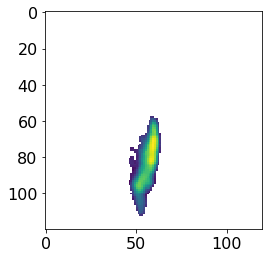

In [126]:
plt.imshow(blue12_3sig_outflow.moment0().data)

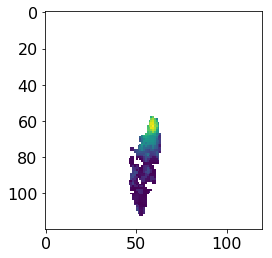

In [128]:
plt.imshow(blue13_3sig_outflow.moment0().data)

0.3452795445919037 K
0.8547889590263367 K
0.82098424
0.9213646054267883 K
-0.019039262 0.90964967


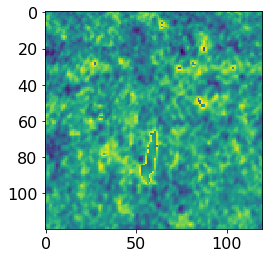

In [124]:
plt.imshow(sub13[9].data)
print(sub13[9].std())
print(sub12[-1].std())
plt.imshow(sub12.with_mask(sub12[0] < 3*sig12)[0].data)
print(np.nanstd(sub12.with_mask(sub12[0] < 3*sig12)[0].data))
c13_noregrid = SpectralCube.read("../../cubes/mask_imfit_13co_pix_2_Tmb.fits")
sub13_noregrid = extract_subcube(c13_noregrid, region_class=RectangleSkyRegion,
                        region_kwargs=dict(center=coord, width=width, height=height))
print(sub13_noregrid[1].std())
print(np.nanmedian(sub13_noregrid[9].data), np.nanstd(sub13_noregrid[-1].data))

c13_noregrid.allow_huge_operations = True
# print(c13_noregrid.std())